In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Estudio de desempleo

## Paso 1: importado de datos CSV

In [37]:
#IMPORTAR CSV
df = pd.read_csv("Data/desempleo.csv")
print('Forma del Dataframe: ',df.shape)
print('Tamaño del Dataframe: ',df.size)

Forma del Dataframe:  (203520, 23)
Tamaño del Dataframe:  4680960


In [38]:
#ESCRIBIR CABECERA (5 ROWS)
df.head(5)

,OBS_STATUS_ID,OBS_STATUS_ID.1,OBS_STATUS_ID.2,OBS_STATUS_ID.3,OBS_STATUS_ID.4,OBS_STATUS_ID.5,OBS_STATUS_ID.6,OBS_STATUS_ID.7,OBS_STATUS_ID.8,OBS_STATUS_ID.9,...,OBS_STATUS_ID.13,OBS_STATUS_ID.14,OBS_STATUS_ID.15,OBS_STATUS_ID.16,OBS_STATUS_ID.17,OBS_STATUS_ID.18,OBS_STATUS_ID.19,OBS_STATUS_NAME,OBS_CONF_ID,OBS_CONF_NAME
0,ABW,Aruba,F,Female,Y15T24,15 to 24 years old,_T,Total,PT,Percentage,...,1960,NaN,WB_GS,Gender Statistics,0,Units,RATIO,Missing value,PU,Public
1,AFE,Africa Eastern and Southern,F,Female,Y15T24,15 to 24 years old,_T,Total,PT,Percentage,...,1960,NaN,WB_GS,Gender Statistics,0,Units,RATIO,Missing value,PU,Public
2,AFG,Afghanistan,F,Female,Y15T24,15 to 24 years old,_T,Total,PT,Percentage,...,1960,NaN,WB_GS,Gender Statistics,0,Units,RATIO,Missing value,PU,Public
3,AFW,Africa Western and Central,F,Female,Y15T24,15 to 24 years old,_T,Total,PT,Percentage,...,1960,NaN,WB_GS,Gender Statistics,0,Units,RATIO,Missing value,PU,Public
4,AGO,Angola,F,Female,Y15T24,15 to 24 years old,_T,Total,PT,Percentage,...,1960,NaN,WB_GS,Gender Statistics,0,Units,RATIO,Missing value,PU,Public


## Paso 2: Limpieza de datos

In [39]:
#EXTRAER EL AÑO 2019
df_2019 = df[df["OBS_STATUS_ID.13"] == 2019]
print('Forma del Dataframe: ',df_2019.shape)
print('Tamaño del Dataframe: ',df_2019.size)

Forma del Dataframe:  (3180, 23)
Tamaño del Dataframe:  73140


In [40]:
# Lista simple de países europeos
europa = [
    "Spain","France","Germany","Italy","Portugal","Belgium","Netherlands","Sweden",
    "Norway","Denmark","Finland","Poland","Austria","Greece","Ireland","Czechia",
    "Slovakia","Slovenia","Hungary","Romania","Bulgaria","Croatia","Estonia",
    "Latvia","Lithuania","Luxembourg","Malta","Iceland","Switzerland","Serbia",
    "Ukraine","Russia","Turkey","Belarus","North Macedonia"
]

# Filtrar países europeos presentes en el dataset
df_europa = df_2019[df_2019["OBS_STATUS_ID.1"].isin(europa)]

In [41]:
df_europa = df_europa.drop(columns=[
    "OBS_STATUS_ID.2",
    "OBS_STATUS_ID.4",
    "OBS_STATUS_ID.6",
    "OBS_STATUS_ID.7",
    "OBS_STATUS_ID.8",
    "OBS_STATUS_ID.9",
    "OBS_STATUS_ID.10",
    "OBS_STATUS_ID.11",
    "OBS_STATUS_ID.12",
    "OBS_STATUS_ID.13",
    "OBS_STATUS_ID.15",
    "OBS_STATUS_ID.16",
    "OBS_STATUS_ID.17",
    "OBS_STATUS_ID.18",
    "OBS_STATUS_ID.19",
    "OBS_STATUS_NAME",
    "OBS_CONF_ID",
    "OBS_CONF_NAME"
])

In [42]:
df_europa.columns = ["ID_Pais", "Pais", "Sexo", "Edad", "Desempleo"]

In [43]:
df_europa.head(10)

,ID_Pais,Pais,Sexo,Edad,Desempleo
187634,AUT,Austria,Female,15 to 24 years old,7944.0
187637,BEL,Belgium,Female,15 to 24 years old,12275.0
187641,BGR,Bulgaria,Female,15 to 24 years old,8322.0
187645,BLR,Belarus,Female,15 to 24 years old,7344.0
187657,CHE,Switzerland,Female,15 to 24 years old,7166.0
187674,CZE,Czechia,Female,15 to 24 years old,5999.0
187675,DEU,Germany,Female,15 to 24 years old,4756.0
187678,DNK,Denmark,Female,15 to 24 years old,9733.0
187690,ESP,Spain,Female,15 to 24 years old,34474.0
187691,EST,Estonia,Female,15 to 24 years old,12098.0


In [44]:
print(df_europa.columns.tolist())

['ID_Pais', 'Pais', 'Sexo', 'Edad', 'Desempleo']


## Paso 3: análisis

In [45]:
# Agrupamos por País y Sexo y calculamos la suma total de desempleo para cada combinación
df_sex_country = df_europa.groupby(["Pais", "Sexo"])["Desempleo"].sum().reset_index()

# Pivotamos para tener el Sexo como columnas y facilitar la comparación
df_sex_pivot = df_sex_country.pivot(index="Pais", columns="Sexo", values="Desempleo").fillna(0)
df_sex_pivot["Total"] = df_sex_pivot["Female"] + df_sex_pivot["Male"]
df_sex_pivot.sort_values(by="Total", ascending=False, inplace=True)

print("===== DESEMPLEO TOTAL (15-24 años) POR PAÍS Y SEXO (2019) =====")
print(df_sex_pivot.head())
print("\n")

# Para identificar el país con mayor y menor desempleo total
max_total_country = df_sex_pivot["Total"].idxmax()
min_total_country = df_sex_pivot["Total"].idxmin()

print(f"País con Mayor Desempleo Total: {max_total_country} → {df_sex_pivot.loc[max_total_country, 'Total']:.0f}")
print(f"País con Menor Desempleo Total: {min_total_country} → {df_sex_pivot.loc[min_total_country, 'Total']:.0f}")

===== DESEMPLEO TOTAL (15-24 años) POR PAÍS Y SEXO (2019) =====
Sexo                Female       Male      Total
Pais                                            
North Macedonia  115102.00  100157.00  215259.00
Greece           116983.00   92751.00  209734.00
Spain             84953.99   74310.45  159264.44
Italy             84637.00   73700.00  158337.00
Serbia            81984.00   71798.00  153782.00


País con Mayor Desempleo Total: North Macedonia → 215259
País con Menor Desempleo Total: Czechia → 30953


## Paso 4: comunicación de datos y visualización

### Mostramos gráficos de Desempleo Femenino vs. Masculino

Interpretación de la Brecha de Género
Barras Rojas/Positivas: Países donde el número de mujeres desempleadas es mayor que el de hombres (ej., Turquía, Italia, Polonia).

Barras Azules/Negativas: Países donde el número de hombres desempleados es mayor que el de mujeres (ej., Suecia, Finlandia, Dinamarca).

Cerca de Cero: Países con un desempleo juvenil más equitativo entre sexos (ej., España, donde ambos sexos tienen un alto número de desempleados, pero la diferencia es menor).

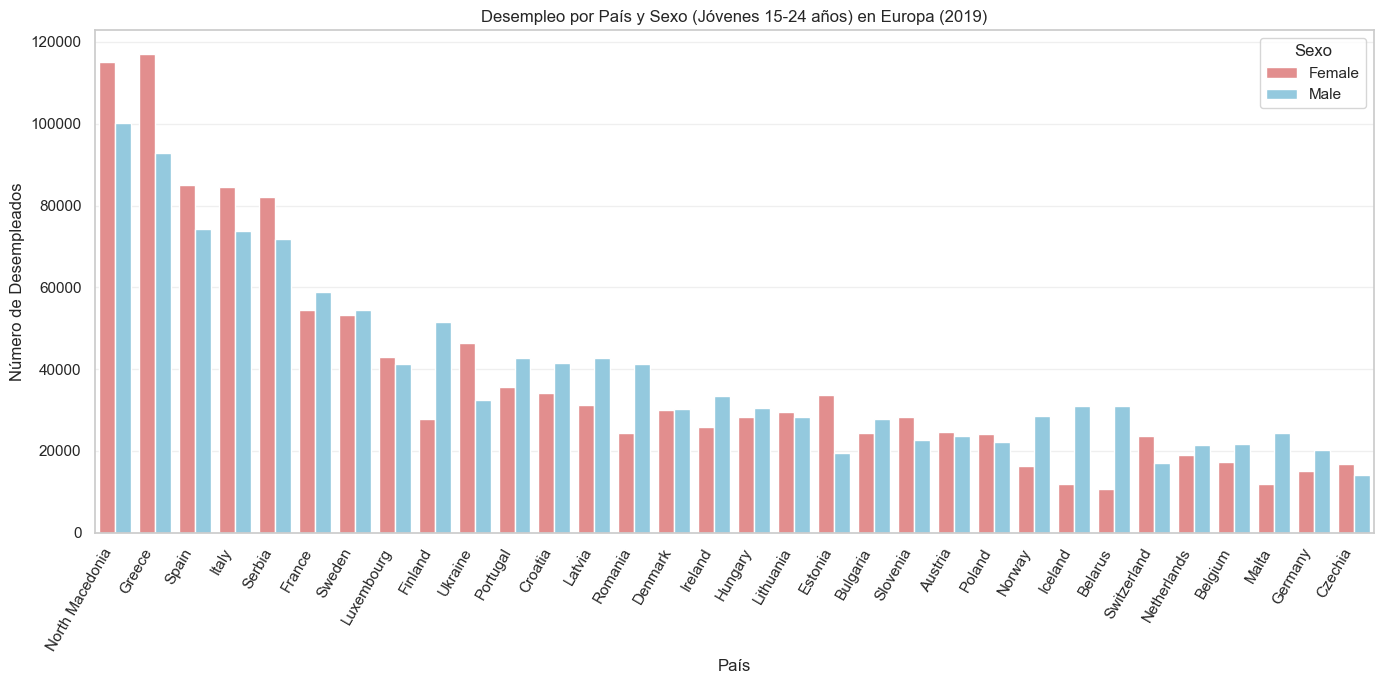

In [ ]:
# Convertir a formato largo (long format) para Seaborn
df_long = df_sex_pivot.reset_index().melt(
    id_vars=df_sex_pivot.index.name, 
    value_vars=["Female", "Male"],
    var_name="Sexo",
    value_name="Desempleo"
)

plt.figure(figsize=(14, 7))

# Gráfico de barras apiladas con Seaborn
sns.barplot(
    data=df_long,
    x=df_sex_pivot.index.name,
    y="Desempleo",
    hue="Sexo",
    palette={"Female": "lightcoral", "Male": "skyblue"},
    estimator=sum,
)

# Ajustar para que sea apilado
# Seaborn no soporta stacking nativamente, así que sumamos manualmente:
# Recalcula posiciones desde el barplot dibujado
ax = plt.gca()
for c in ax.containers:
    # valores de cada categoría
    labels = [v.get_height() for v in c]
    # Mostrar valores si quieres: ax.bar_label(c, label_type="center")

# Título y etiquetas
plt.title("Desempleo por País y Sexo (Jóvenes 15-24 años) en Europa (2019)")
plt.ylabel("Número de Desempleados")
plt.xlabel("País")
plt.xticks(rotation=60, ha='right')
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


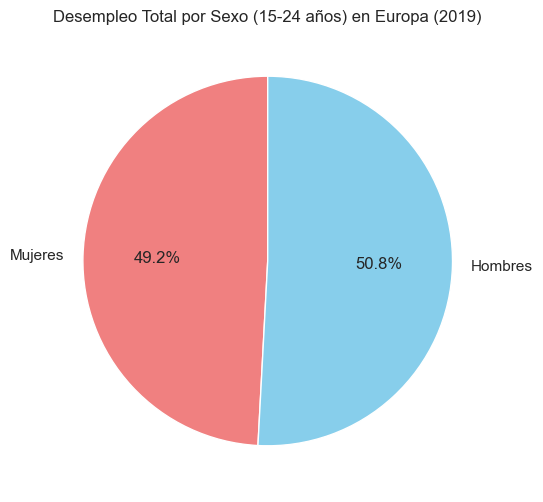

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Activar estilo de Seaborn
sns.set_theme(style="whitegrid")

# Totales por sexo
totales = df_sex_pivot[["Female", "Male"]].sum()

plt.figure(figsize=(6, 6))
plt.pie(
    totales,
    labels=["Mujeres", "Hombres"],
    autopct='%1.1f%%',
    colors=["lightcoral", "skyblue"],
    startangle=90
)

plt.title("Desempleo Total por Sexo (15-24 años) en Europa (2019)")
plt.show()


## Paso extra: preparación de datos para uso de compañeros

### Aquí escribo un resumen de los dataframes y series utilizados en limpio para facilitar la extracción de los mismos por parte de mis compañeros

In [48]:
#Paises en español
paises_es = {
    "Austria": "Austria",
    "Belgium": "Bélgica",
    "Bulgaria": "Bulgaria",
    "Belarus": "Bielorrusia",
    "Switzerland": "Suiza",
    "Germany": "Alemania",
    "France": "Francia",
    "Italy": "Italia",
    "Spain": "España",
    "Portugal": "Portugal",
    "Netherlands": "Países Bajos",
    "Greece": "Grecia",
    "Poland": "Polonia",
    "Sweden": "Suecia",
    "Norway": "Noruega",
    "Finland": "Finlandia",
    "Denmark": "Dinamarca",
    "Ireland": "Irlanda",
    "United Kingdom": "Reino Unido",
    "Czech Republic": "República Checa",
    "Slovakia": "Eslovaquia",
    "Slovenia": "Eslovenia",
    "Croatia": "Croacia",
    "Czechia": "República Checa",
    "Hungary": "Hungría",
    "Romania": "Rumanía",
    "Estonia": "Estonia",
    "Latvia": "Letonia",
    "Lithuania": "Lituania",
    "Luxembourg": "Luxemburgo",
    "Malta": "Malta",
    "Cyprus": "Chipre",
    "Iceland": "Islandia",
    "Serbia": "Serbia",
    "Montenegro": "Montenegro",
    "North Macedonia": "Macedonia del Norte",
    "Albania": "Albania",
    "Bosnia and Herzegovina": "Bosnia y Herzegovina",
    "Ukraine": "Ucrania",
    "Moldova": "Moldavia",
    "Russia": "Rusia",
    "Turkey": "Turquía"
}

df_europa['Pais'] = df_europa['Pais'].map(paises_es).fillna(df_europa['Pais'])


In [49]:
df_europa.head(10)

,ID_Pais,Pais,Sexo,Edad,Desempleo
187634,AUT,Austria,Female,15 to 24 years old,7944.0
187637,BEL,Bélgica,Female,15 to 24 years old,12275.0
187641,BGR,Bulgaria,Female,15 to 24 years old,8322.0
187645,BLR,Bielorrusia,Female,15 to 24 years old,7344.0
187657,CHE,Suiza,Female,15 to 24 years old,7166.0
187674,CZE,República Checa,Female,15 to 24 years old,5999.0
187675,DEU,Alemania,Female,15 to 24 years old,4756.0
187678,DNK,Dinamarca,Female,15 to 24 years old,9733.0
187690,ESP,España,Female,15 to 24 years old,34474.0
187691,EST,Estonia,Female,15 to 24 years old,12098.0


In [50]:
# 1. RECONSTRUIR df_sex_pivot con todas las columnas
# (Esta línea soluciona el KeyError, ya que añade de nuevo la columna "Brecha (F - M)")
df_sex_pivot = df_europa.groupby(["Pais", "Sexo"])["Desempleo"].sum().unstack(fill_value=0)
df_sex_pivot["Total"] = df_sex_pivot["Female"] + df_sex_pivot["Male"]
df_sex_pivot["Brecha (F - M)"] = df_sex_pivot["Female"] - df_sex_pivot["Male"]
df_sex_pivot.sort_values(by="Total", ascending=False, inplace=True) # Reordenar por el total

# 2. DATAFRAMES EXTRAIDOS
df_final_europa = df_europa.copy()
df_desempleo_sexo_pais = df_sex_pivot[["Female", "Male", "Total", "Brecha (F - M)"]].copy()

# -----------------------------------------------------------------------

print('RESUMEN DE DATAFRAMES EXTRAIDOS:')
print("-" * 50)

print("1. DATAFRAME LIMPIO (Europa, 2019, 15-24):")
print(df_final_europa.head())
print("_" * 50)

print("2. DESEMPLEO JUVENIL POR SEXO Y PAÍS (con Brecha F-M):")
print(df_desempleo_sexo_pais.head())
print("_" * 50)

# Guardar los DataFrames finales en CSV
df_final_europa.to_csv("df_final_europa_desempleo.csv", index=False)
df_desempleo_sexo_pais.to_csv("df_desempleo_sexo_pais_resumen.csv", index=True)

print("\n")
print("DataFrames guardados como CSV:")
print("- df_final_europa_desempleo.csv")
print("- df_desempleo_sexo_pais_resumen.csv")

RESUMEN DE DATAFRAMES EXTRAIDOS:
--------------------------------------------------
1. DATAFRAME LIMPIO (Europa, 2019, 15-24):
       ID_Pais         Pais    Sexo                Edad  Desempleo
187634     AUT      Austria  Female  15 to 24 years old     7944.0
187637     BEL      Bélgica  Female  15 to 24 years old    12275.0
187641     BGR     Bulgaria  Female  15 to 24 years old     8322.0
187645     BLR  Bielorrusia  Female  15 to 24 years old     7344.0
187657     CHE        Suiza  Female  15 to 24 years old     7166.0
__________________________________________________
2. DESEMPLEO JUVENIL POR SEXO Y PAÍS (con Brecha F-M):
Sexo                    Female       Male      Total  Brecha (F - M)
Pais                                                                
Macedonia del Norte  115102.00  100157.00  215259.00        14945.00
Grecia               116983.00   92751.00  209734.00        24232.00
España                84953.99   74310.45  159264.44        10643.54
Italia              